In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from rex import init_logger
import torch
from sympy import (
    symbols,
    sqrt,
    simplify,
    expand,
    nsimplify,
    parse_expr,
    sympify,
)
import sympy
import cProfile, pstats, io
from pstats import SortKey
from rl_equation_solver.agent.linear_a2c import Agent as LinearA2C
from rl_equation_solver.agent.graph_a2c import Agent as GraphA2C
from rl_equation_solver.agent.graph_lstm_a2c import Agent as GraphLstmA2C

In [3]:
init_logger(__name__, log_level="INFO")
init_logger("rl_equation_solver", log_level="INFO")

<Logger rl_equation_solver (INFO)>

In [4]:
def reject_outliers(x, data, m=2):
    mask = abs(data - np.mean(data)) < m * np.std(data)
    return np.array(x)[mask], np.array(data)[mask]

In [5]:
# plot reward distribution
def plot_reward_dist(env):
    _, ax = plt.subplots(1, 1)
    ax.hist(env.avg_history["reward"])
    ax.set_ylabel("Count")
    ax.set_xlabel("Reward")
    plt.show()

# plot complexity, loss, reward
def plot_trends(env):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax = axes.flatten()
    history = env.total_history

    x = np.arange(len(history["ep"]))
    y = history["complexity"]
    #x, y = reject_outliers(x, y)
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(a * x + b, color="r")

    y = history["loss"]
    x = np.arange(len(history['ep']))
    #x, y = reject_outliers(x, y)
    mask = np.array([i for i, v in enumerate(y) if not np.isnan(v)])
    mask = slice(mask[0], mask[-1] + 1)
    a, b = np.polyfit(x[mask], y[mask], 1)
    ax[1].scatter(x[mask], y[mask])
    ax[1].plot(x[mask], a * x[mask] + b, color="r")

    y = history["reward"]
    x = np.arange(len(history['ep']))
    #x, y = reject_outliers(x, y)
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(a * x + b, color="r")

    y = history["loop_step"]
    x = np.arange(len(history['ep']))
    #x, y = reject_outliers(x, y)
    a, b = np.polyfit(x, y, 1)
    ax[3].scatter(x, y)
    ax[3].plot(a * x + b, color="r")

    ax[0].set_title("Complexity")
    ax[1].set_title("Loss")
    ax[2].set_title("Reward")
    ax[3].set_title("Steps")

    plt.show()

## Initialize Env and Agent ##
### Agent can be AgentGCN, AgentLSTM, AgentDQN ###

In [6]:
env = Env(order=2, config={"reward_function": "diff_loss_reward", "state_dim": 128})

INFO - 2023-05-07 20:48:18,099 [algebraic.py:116] : Initializing environment with order=2, |S| = 10 x 128 = 1280
INFO - 2023-05-07 20:48:18,099 [algebraic.py:121] : Using reward function: diff_loss_reward.


In [7]:
config = {"learning_rate": 5e-4, "device": "cuda:0", "update_freq": 30, 'grad_clip': 100, 'max_solution_steps': 10000, 'state_dim': 128}

In [9]:
#agent = GraphLstmA2C(env=env, config=config)
#agent = AgentGCN(env=env, config=config)
#agent = LinearA2C(env=env, config=config)
agent = GraphA2C(env=env, config=config)

INFO - 2023-05-07 20:48:35,961 [base.py:79] : Initialized Agent with config: {'batch_size': 32, 'gamma': 0.9, 'learning_rate': 0.0005, 'hidden_size': 64, 'memory_cap': 10000, 'fill_memory_steps': 64, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 100, 'device': 'cuda:0', 'entropy_coef': 0.3, 'critic_coef': 0.8}
INFO - 2023-05-07 20:48:35,962 [base.py:61] : Initialized Agent with device cuda:0


In [10]:
agent.update_config(config)

INFO - 2023-05-07 20:48:36,890 [base.py:79] : Initialized Agent with config: {'batch_size': 32, 'gamma': 0.9, 'learning_rate': 0.0005, 'hidden_size': 64, 'memory_cap': 10000, 'fill_memory_steps': 64, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 100, 'device': 'cuda:0', 'entropy_coef': 0.3, 'critic_coef': 0.8}


## Train Agent ##

In [11]:
for _ in range(1):
    agent.train(1000, progress_bar=True)

INFO - 2023-05-07 20:48:37,859 [base.py:238] : Running training routine for 1000 episodes in eval=False mode.


{'ep': '1   ', 'step': '10603', 'loop_step': '10000', 'complexity': '925      ', 'loss': '3.49e+00 ', 'reward': '-2.0     ', 'state': '0**a0 + 1 - 898*a1  '}: : 1it [08:56, 25.52s/it]  

INFO - 2023-05-07 20:57:34,346 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '2   ', 'step': '20605', 'loop_step': '10000', 'complexity': '10030    ', 'loss': '1.18e+01 ', 'reward': '-2.0     ', 'state': '0 - a0 - 10000*a1   '}: : 2it [17:41, 310.97s/it]

INFO - 2023-05-07 21:06:19,958 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '3   ', 'step': '30607', 'loop_step': '10000', 'complexity': '10026    ', 'loss': '3.39e-01 ', 'reward': '-2.0     ', 'state': '0**a0 + 1 - 9999*a1 '}: : 3it [26:39, 408.98s/it]

INFO - 2023-05-07 21:15:17,350 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '4   ', 'step': '40609', 'loop_step': '10000', 'complexity': '8392     ', 'loss': '6.48e-01 ', 'reward': '-2.0     ', 'state': '0**a0 + a0 - 8363*a1'}: : 4it [35:05, 459.67s/it]     

INFO - 2023-05-07 21:23:43,186 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '5   ', 'step': '50611', 'loop_step': '10000', 'complexity': '33       ', 'loss': '6.20e+00 ', 'reward': '0.0      ', 'state': '0 - 1 + 3*a0        '}: : 5it [43:09, 476.32s/it] 

INFO - 2023-05-07 21:31:47,219 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '6   ', 'step': '60613', 'loop_step': '10000', 'complexity': '33       ', 'loss': '1.59e+00 ', 'reward': '-4.0     ', 'state': '0 + 3*a0 - a1       '}: : 6it [50:58, 478.94s/it]

INFO - 2023-05-07 21:39:36,770 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '7   ', 'step': '70615', 'loop_step': '10000', 'complexity': '185      ', 'loss': '6.02e+01 ', 'reward': '-2.0     ', 'state': '0 - 90*1 + 60*a0 + a1'}: : 7it [59:13, 475.87s/it] 

INFO - 2023-05-07 21:47:51,914 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '8   ', 'step': '80617', 'loop_step': '10000', 'complexity': '7266     ', 'loss': '1.55e+01 ', 'reward': '-2.0     ', 'state': '0 + 327*1 - 6904*a0 + a1'}: : 8it [1:08:58, 482.01s/it]

INFO - 2023-05-07 21:57:36,347 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '9   ', 'step': '90619', 'loop_step': '10000', 'complexity': '82       ', 'loss': '-2.63e+00', 'reward': '0.0      ', 'state': '0 + 30*1 - 23*a0    '}: : 9it [1:17:03, 514.03s/it]    

INFO - 2023-05-07 22:05:41,478 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '10  ', 'step': '100621', 'loop_step': '10000', 'complexity': '40       ', 'loss': '3.08e-01 ', 'reward': '3.0      ', 'state': '0 + 15*1 + a0       '}: : 10it [1:25:02, 505.11s/it]

INFO - 2023-05-07 22:13:40,351 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '11  ', 'step': '110623', 'loop_step': '10000', 'complexity': '75       ', 'loss': '2.21e+00 ', 'reward': '0.0      ', 'state': '0 - 44*1 + a0 + a1  '}: : 11it [1:32:53, 497.08s/it]

INFO - 2023-05-07 22:21:31,784 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '12  ', 'step': '120625', 'loop_step': '10000', 'complexity': '8946     ', 'loss': '2.45e+00 ', 'reward': '-2.0     ', 'state': '0 + 834*1 - 8077*a0 + a1'}: : 12it [1:43:03, 489.28s/it]

INFO - 2023-05-07 22:31:41,179 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '13  ', 'step': '130627', 'loop_step': '10000', 'complexity': '45       ', 'loss': '-7.20e+00', 'reward': '0.0      ', 'state': '0 + 13*1 - 3*a0     '}: : 13it [1:50:58, 525.66s/it]    

INFO - 2023-05-07 22:39:36,663 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '14  ', 'step': '140629', 'loop_step': '10000', 'complexity': '32       ', 'loss': '2.66e+01 ', 'reward': '-3.0     ', 'state': '0 - 1 - 2*a0        '}: : 14it [1:58:19, 510.51s/it]

INFO - 2023-05-07 22:46:57,891 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '15  ', 'step': '150631', 'loop_step': '10000', 'complexity': '52       ', 'loss': '-2.21e-01', 'reward': '0.0      ', 'state': '0 - 10*1 + 13*a0    '}: : 15it [2:05:42, 489.62s/it]

INFO - 2023-05-07 22:54:20,428 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '16  ', 'step': '160633', 'loop_step': '10000', 'complexity': '38       ', 'loss': '1.39e+01 ', 'reward': '0.0      ', 'state': '0 + 8*1 - a0        '}: : 16it [2:13:13, 475.45s/it]

INFO - 2023-05-07 23:01:51,612 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '17  ', 'step': '170635', 'loop_step': '10000', 'complexity': '54       ', 'loss': '1.24e+01 ', 'reward': '0.0      ', 'state': '0 - 7*1 + 18*a0     '}: : 17it [2:20:58, 468.15s/it]

INFO - 2023-05-07 23:09:36,280 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '18  ', 'step': '180637', 'loop_step': '10000', 'complexity': '83       ', 'loss': '-3.61e-01', 'reward': '-2.0     ', 'state': '0 - 11*1 + 43*a0    '}: : 18it [2:28:31, 467.11s/it]

INFO - 2023-05-07 23:17:09,921 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '19  ', 'step': '190639', 'loop_step': '10000', 'complexity': '29       ', 'loss': '6.77e+00 ', 'reward': '-2.0     ', 'state': '0 + 4*1 + a0        '}: : 19it [2:36:44, 463.06s/it]

INFO - 2023-05-07 23:25:22,794 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '20  ', 'step': '200641', 'loop_step': '10000', 'complexity': '57       ', 'loss': '2.82e+00 ', 'reward': '-2.0     ', 'state': '0 + 24*1 - 4*a0     '}: : 20it [2:44:24, 472.01s/it]

INFO - 2023-05-07 23:33:02,152 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '21  ', 'step': '210643', 'loop_step': '10000', 'complexity': '41       ', 'loss': '9.08e+00 ', 'reward': '-2.0     ', 'state': '0 + 10*1 - 2*a0     '}: : 21it [2:51:52, 468.21s/it]

INFO - 2023-05-07 23:40:30,820 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '22  ', 'step': '220645', 'loop_step': '10000', 'complexity': '30       ', 'loss': '-2.67e+00', 'reward': '2.0      ', 'state': '0 + 2*1 - a0        '}: : 22it [2:58:47, 462.35s/it]

INFO - 2023-05-07 23:47:25,863 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '23  ', 'step': '230647', 'loop_step': '10000', 'complexity': '133      ', 'loss': '4.76e+00 ', 'reward': '-2.0     ', 'state': '0 - 34*1 + 70*a0    '}: : 23it [3:05:22, 448.15s/it]

INFO - 2023-05-07 23:54:00,149 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '24  ', 'step': '240649', 'loop_step': '10000', 'complexity': '5        ', 'loss': '3.69e+03 ', 'reward': '3.0      ', 'state': '0/a0                '}: : 24it [3:12:46, 431.99s/it]

INFO - 2023-05-08 00:01:24,420 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '25  ', 'step': '250651', 'loop_step': '10000', 'complexity': '32       ', 'loss': '1.92e+03 ', 'reward': '-3.0     ', 'state': '0 - 2*1 - a0        '}: : 25it [3:19:30, 435.67s/it]

INFO - 2023-05-08 00:08:08,939 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '26  ', 'step': '260653', 'loop_step': '10000', 'complexity': '33       ', 'loss': '1.22e+01 ', 'reward': '3.0      ', 'state': '0 - 2*1 + a0 + a1   '}: : 26it [3:26:30, 426.33s/it]  

INFO - 2023-05-08 00:15:08,657 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '27  ', 'step': '270655', 'loop_step': '10000', 'complexity': '2230     ', 'loss': '-2.26e+00', 'reward': '-2.0     ', 'state': '0 + 829*1 - 1366*a0 + a1'}: : 27it [3:35:33, 424.34s/it]

INFO - 2023-05-08 00:24:11,728 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '28  ', 'step': '280657', 'loop_step': '10000', 'complexity': '21       ', 'loss': '1.57e+01 ', 'reward': '2.0      ', 'state': '0 + 2*a0            '}: : 28it [3:43:19, 459.96s/it]    

INFO - 2023-05-08 00:31:57,553 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '29  ', 'step': '290659', 'loop_step': '10000', 'complexity': '8386     ', 'loss': '6.02e+00 ', 'reward': '-2.0     ', 'state': '0 + 2282*1 - 6069*a0 + a1'}: : 29it [3:53:14, 461.72s/it]

INFO - 2023-05-08 00:41:52,221 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '30  ', 'step': '300661', 'loop_step': '10000', 'complexity': '52       ', 'loss': '4.72e+00 ', 'reward': '0.0      ', 'state': '0 + 21*1 + a0 + a1  '}: : 30it [4:01:22, 501.61s/it]     

INFO - 2023-05-08 00:50:00,783 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '31  ', 'step': '310663', 'loop_step': '10000', 'complexity': '6355     ', 'loss': '2.14e+00 ', 'reward': '-2.0     ', 'state': '0 + 1950*1 - 4370*a0 + a1'}: : 31it [4:11:12, 497.69s/it]

INFO - 2023-05-08 00:59:50,154 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '32  ', 'step': '320665', 'loop_step': '10000', 'complexity': '4147     ', 'loss': '3.48e-01 ', 'reward': '-2.0     ', 'state': '0 + 1276*1 - 2836*a0 + a1'}: : 32it [4:19:54, 525.20s/it]

INFO - 2023-05-08 01:08:32,358 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '33  ', 'step': '330667', 'loop_step': '10000', 'complexity': '54       ', 'loss': '3.41e+00 ', 'reward': '-9.0     ', 'state': '0**a0 + 25*1 + a0   '}: : 33it [4:27:22, 524.30s/it]     

INFO - 2023-05-08 01:16:00,513 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '34  ', 'step': '340669', 'loop_step': '10000', 'complexity': '29       ', 'loss': '1.60e+00 ', 'reward': '1.0      ', 'state': '0 + 1 + a0 + a1     '}: : 34it [4:34:06, 501.46s/it]

INFO - 2023-05-08 01:22:44,850 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '35  ', 'step': '350671', 'loop_step': '10000', 'complexity': '52       ', 'loss': '1.63e+00 ', 'reward': '-2.0     ', 'state': '0 - 16*1 - a0 + a1  '}: : 35it [4:40:03, 472.32s/it]

INFO - 2023-05-08 01:28:41,339 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '36  ', 'step': '360673', 'loop_step': '10000', 'complexity': '13       ', 'loss': '9.93e+00 ', 'reward': '8.0      ', 'state': '0**a0               '}: : 36it [4:46:05, 437.57s/it]

INFO - 2023-05-08 01:34:43,687 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '37  ', 'step': '370675', 'loop_step': '10000', 'complexity': '20       ', 'loss': '1.07e+01 ', 'reward': '-2.0     ', 'state': '0 - 3*1             '}: : 37it [4:51:38, 415.00s/it]

INFO - 2023-05-08 01:40:16,283 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '38  ', 'step': '380677', 'loop_step': '10000', 'complexity': '5        ', 'loss': '3.25e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 38it [4:56:47, 390.28s/it]

INFO - 2023-05-08 01:45:25,182 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '39  ', 'step': '390679', 'loop_step': '10000', 'complexity': '14       ', 'loss': '2.33e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 39it [5:01:55, 365.87s/it]

INFO - 2023-05-08 01:50:33,567 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '40  ', 'step': '400681', 'loop_step': '10000', 'complexity': '5        ', 'loss': '1.35e+01 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 40it [5:06:59, 348.62s/it]

INFO - 2023-05-08 01:55:37,547 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '41  ', 'step': '410683', 'loop_step': '10000', 'complexity': '14       ', 'loss': '7.55e+00 ', 'reward': '0.0      ', 'state': '0/a0 - 1            '}: : 41it [5:11:48, 335.23s/it]

INFO - 2023-05-08 02:00:26,570 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '42  ', 'step': '420685', 'loop_step': '10000', 'complexity': '5        ', 'loss': '2.78e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 42it [5:16:39, 321.37s/it]

INFO - 2023-05-08 02:05:17,378 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '43  ', 'step': '430687', 'loop_step': '10000', 'complexity': '14       ', 'loss': '4.34e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 43it [5:21:38, 312.20s/it]

INFO - 2023-05-08 02:10:16,125 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '44  ', 'step': '440689', 'loop_step': '10000', 'complexity': '5        ', 'loss': '3.23e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 44it [5:26:25, 308.16s/it]

INFO - 2023-05-08 02:15:03,644 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '45  ', 'step': '450691', 'loop_step': '10000', 'complexity': '11       ', 'loss': '-4.68e-01', 'reward': '-7.0     ', 'state': '0/a0 + 1            '}: : 45it [5:31:13, 301.97s/it]

INFO - 2023-05-08 02:19:51,227 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '46  ', 'step': '460693', 'loop_step': '10000', 'complexity': '14       ', 'loss': '-1.62e+00', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 46it [5:35:58, 297.65s/it]

INFO - 2023-05-08 02:24:37,050 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '47  ', 'step': '470695', 'loop_step': '10000', 'complexity': '11       ', 'loss': '1.18e+00 ', 'reward': '-7.0     ', 'state': '0/a0 + 1            '}: : 47it [5:40:47, 294.10s/it]

INFO - 2023-05-08 02:29:25,588 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '48  ', 'step': '480697', 'loop_step': '10000', 'complexity': '20       ', 'loss': '8.97e+00 ', 'reward': '-2.0     ', 'state': '0 - 3*1             '}: : 48it [5:45:50, 292.43s/it]

INFO - 2023-05-08 02:34:28,428 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '49  ', 'step': '490699', 'loop_step': '10000', 'complexity': '14       ', 'loss': '-1.75e-01', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 49it [5:50:44, 295.56s/it]

INFO - 2023-05-08 02:39:22,407 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '50  ', 'step': '500701', 'loop_step': '10000', 'complexity': '72       ', 'loss': '4.71e+01 ', 'reward': '-2.0     ', 'state': '0**a0 + 51*1        '}: : 50it [5:55:51, 295.08s/it]

INFO - 2023-05-08 02:44:29,977 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '51  ', 'step': '510703', 'loop_step': '10000', 'complexity': '16       ', 'loss': '-4.18e+00', 'reward': '-2.0     ', 'state': '0/a0 + 3*1          '}: : 51it [6:01:15, 298.83s/it]

INFO - 2023-05-08 02:49:54,028 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '52  ', 'step': '520705', 'loop_step': '10000', 'complexity': '14       ', 'loss': '1.27e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 52it [6:06:13, 306.40s/it]

INFO - 2023-05-08 02:54:51,688 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '53  ', 'step': '530707', 'loop_step': '10000', 'complexity': '5        ', 'loss': '2.37e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 53it [6:11:13, 303.77s/it]

INFO - 2023-05-08 02:59:51,754 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '54  ', 'step': '540709', 'loop_step': '10000', 'complexity': '22       ', 'loss': '1.17e+01 ', 'reward': '-10.0    ', 'state': '0**a0 - 1           '}: : 54it [6:16:39, 302.66s/it]

INFO - 2023-05-08 03:05:17,232 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '55  ', 'step': '550711', 'loop_step': '10000', 'complexity': '5        ', 'loss': '7.20e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 55it [6:21:49, 309.51s/it]

INFO - 2023-05-08 03:10:27,681 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '56  ', 'step': '560713', 'loop_step': '10000', 'complexity': '5        ', 'loss': '4.10e+03 ', 'reward': '3.0      ', 'state': '0/a0                '}: : 56it [6:26:43, 309.79s/it]

INFO - 2023-05-08 03:15:21,662 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '57  ', 'step': '570715', 'loop_step': '10000', 'complexity': '14       ', 'loss': '1.05e+03 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 57it [6:31:28, 305.05s/it]

INFO - 2023-05-08 03:20:06,684 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '58  ', 'step': '580717', 'loop_step': '10000', 'complexity': '15       ', 'loss': '1.04e+00 ', 'reward': '-2.0     ', 'state': '0/a0 - 2*1          '}: : 58it [6:36:15, 299.04s/it]

INFO - 2023-05-08 03:24:53,478 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '59  ', 'step': '590719', 'loop_step': '10000', 'complexity': '14       ', 'loss': '4.23e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 59it [6:40:58, 295.37s/it]

INFO - 2023-05-08 03:29:36,465 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '60  ', 'step': '600721', 'loop_step': '10000', 'complexity': '14       ', 'loss': '5.01e+03 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 60it [6:45:48, 291.65s/it]

INFO - 2023-05-08 03:34:26,155 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '61  ', 'step': '610723', 'loop_step': '10000', 'complexity': '5        ', 'loss': '1.32e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 61it [6:50:42, 291.06s/it]

INFO - 2023-05-08 03:39:20,806 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '62  ', 'step': '620725', 'loop_step': '10000', 'complexity': '14       ', 'loss': '4.74e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 62it [6:55:25, 292.14s/it]

INFO - 2023-05-08 03:44:03,819 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '63  ', 'step': '630727', 'loop_step': '10000', 'complexity': '5        ', 'loss': '4.53e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 63it [7:00:14, 289.41s/it]

INFO - 2023-05-08 03:48:52,617 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '64  ', 'step': '640729', 'loop_step': '10000', 'complexity': '14       ', 'loss': '7.14e-01 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 64it [7:04:57, 289.22s/it]

INFO - 2023-05-08 03:53:36,063 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '65  ', 'step': '650731', 'loop_step': '10000', 'complexity': '14       ', 'loss': '1.86e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 65it [7:09:38, 287.49s/it]

INFO - 2023-05-08 03:58:16,403 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '66  ', 'step': '660733', 'loop_step': '10000', 'complexity': '5        ', 'loss': '1.25e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 66it [7:14:22, 285.34s/it]

INFO - 2023-05-08 04:03:00,730 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '67  ', 'step': '670735', 'loop_step': '10000', 'complexity': '13       ', 'loss': '8.09e+00 ', 'reward': '8.0      ', 'state': '0**a0               '}: : 67it [7:19:22, 285.04s/it]

INFO - 2023-05-08 04:08:00,565 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '68  ', 'step': '680737', 'loop_step': '10000', 'complexity': '27       ', 'loss': '1.45e+01 ', 'reward': '-2.0     ', 'state': '0 - 10*1            '}: : 68it [7:24:28, 289.48s/it]

INFO - 2023-05-08 04:13:06,441 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '69  ', 'step': '690739', 'loop_step': '10000', 'complexity': '14       ', 'loss': '2.79e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 69it [7:29:36, 294.40s/it]

INFO - 2023-05-08 04:18:14,218 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '70  ', 'step': '700741', 'loop_step': '10000', 'complexity': '14       ', 'loss': '3.56e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 70it [7:34:23, 298.41s/it]

INFO - 2023-05-08 04:23:01,999 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '71  ', 'step': '710743', 'loop_step': '10000', 'complexity': '5        ', 'loss': '1.63e+00 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 71it [7:39:08, 295.22s/it]

INFO - 2023-05-08 04:27:46,997 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '72  ', 'step': '720745', 'loop_step': '10000', 'complexity': '5        ', 'loss': '2.02e+01 ', 'reward': '8.0      ', 'state': '0/a0                '}: : 72it [7:43:58, 292.15s/it]

INFO - 2023-05-08 04:32:36,504 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '73  ', 'step': '730747', 'loop_step': '10000', 'complexity': '5        ', 'loss': '-3.77e-01', 'reward': '8.0      ', 'state': '0/a0                '}: : 73it [7:48:42, 291.36s/it]

INFO - 2023-05-08 04:37:20,548 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '74  ', 'step': '740749', 'loop_step': '10000', 'complexity': '5        ', 'loss': '-1.56e-01', 'reward': '8.0      ', 'state': '0/a0                '}: : 74it [7:53:26, 289.17s/it]

INFO - 2023-05-08 04:42:04,775 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '75  ', 'step': '750751', 'loop_step': '10000', 'complexity': '14       ', 'loss': '2.33e+03 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 75it [7:58:54, 287.68s/it]

INFO - 2023-05-08 04:47:32,304 [algebraic.py:472] : loop_step 10001 exceeded max 10000


{'ep': '76  ', 'step': '756742', 'loop_step': '5989', 'complexity': '14       ', 'loss': '1.95e+00 ', 'reward': '-10.0    ', 'state': '0/a0 - 1            '}: : 76it [8:02:06, 299.64s/it] 

## Plot Reward Distribution ##

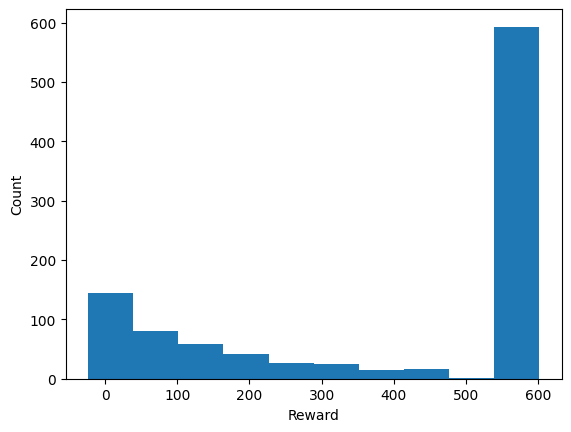

In [13]:
plot_reward_dist(env)

## Plot complexity, loss, and reward trend ##

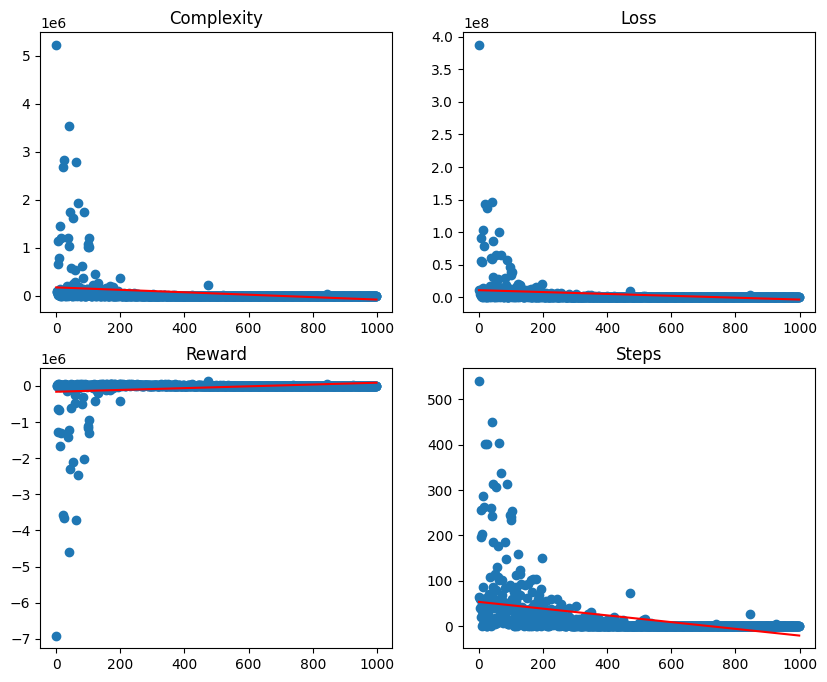

In [14]:
plot_trends(env)

## Run trained agent in eval mode ##

In [10]:
agent.train(10, eval=True)

INFO - 2023-04-27 18:27:12,517 [base.py:231] : Running training routine for 10 episodes in eval=True mode.


{'ep': '109 ', 'step': '2950', 'loop_step': '1   ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '5.18e+02 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}: : 10it [00:00, 14.83it/s]


In [11]:
history = env.best_history
best_i = np.argmax(history["reward"])
print(parse_expr(str(history["state"][best_i])))
print(history["reward"][best_i])

-a1/a0
518.0


c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\utilities\history.py:114: RuntimeWarning: All-NaN axis encountered
  out[k].append(np.nanmin(series[k]))


## Plot reward distribution for trained agent ##

c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\utilities\history.py:100: RuntimeWarning: Mean of empty slice
  out[k].append(np.nanmean(series[k]))


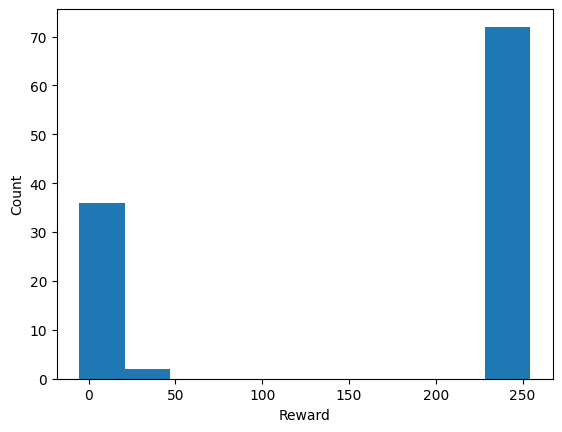

In [12]:
plot_reward_dist(env)

## Render final state graph ##

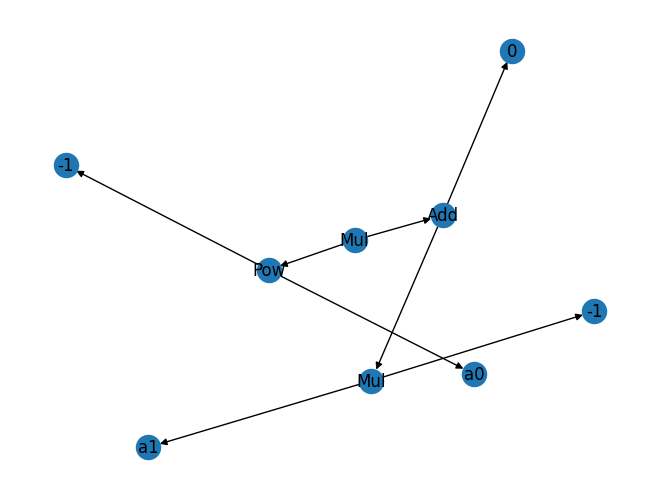

In [13]:
nx.draw(env.state_graph, labels=env.node_labels)

## Run new Agent in eval mode ##

In [150]:
env = Env(order=2)
agent = AgentGCN(env, device="cuda:0")
agent.train(30, eval=True)

INFO - 2023-04-17 13:10:35,160 [algebraic.py:112] : Initializing environment with order=2, |S| = 11 x 64 = 704
INFO - 2023-04-17 13:10:35,163 [gcn.py:37] : Initialized Agent with device cuda:0
INFO - 2023-04-17 13:10:35,169 [base.py:298] : Running training routine for 30 episodes in eval=True mode.
INFO - 2023-04-17 13:10:35,194 [history.py:76] : 
{'ep': 0, 'step': 1, 'complexity': 14.0, 'loss': 'nan', 'reward': '-8.000e+00', 'state': 1/a1, 'approx': a0/a1 + a1}
INFO - 2023-04-17 13:10:35,196 [base.py:347] : 
Solver terminated after 3 steps: total_reward = -1.700e+01, mean_loss = nan, state = 1/a1
INFO - 2023-04-17 13:10:35,306 [history.py:76] : 
{'ep': 1, 'step': 8, 'complexity': 18.0, 'loss': 'nan', 'reward': '-4.000e+00', 'state': a0 - a1, 'approx': a0*(a0 - a1) + a1}
INFO - 2023-04-17 13:10:35,309 [base.py:347] : 
Solver terminated after 8 steps: total_reward = -1.700e+01, mean_loss = nan, state = a0 - a1
INFO - 2023-04-17 13:10:35,344 [history.py:76] : 
{'ep': 2, 'step': 11, 'comp

## Plot reward distribution for untrained agent ##

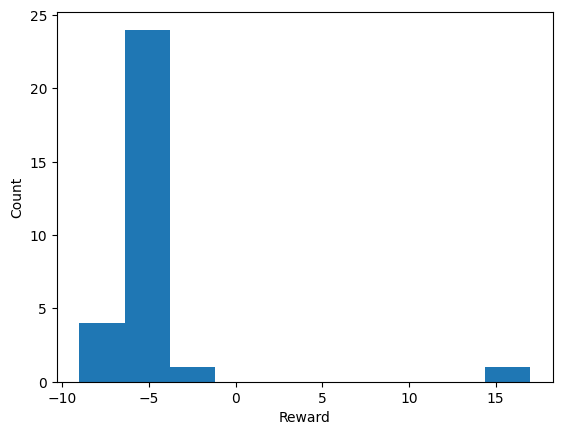

In [151]:
plot_reward_dist(env)